Name- Vaibhav Gupta

Roll No.- 20IE10041

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tensorflow import keras
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy, Precision, Recall,ConfusionMatrix

In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed for reproducibility
torch.manual_seed(42)

# Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=28, padding=4),
    transforms.ToTensor(),
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='.', train=True, transform=train_transform, download=True)
test_dataset = datasets.MNIST(root='.', train=False, transform=transforms.ToTensor(), download=True)

# Split dataset into train and validation sets
train_indices, val_indices = train_test_split(list(range(len(train_dataset))), test_size=0.1, random_state=42)
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Feedforward Neural Network Model
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Hyperparameters
input_size = 28 * 28  # MNIST image size
hidden_size = 128
num_classes = int(10)
learning_rate = 0.001
epochs = 10

# Initialize model, loss function, and optimizer
model = FFNN(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and Evaluation
train_losses = []
val_losses = []
test_losses= []

accuracy = Accuracy(num_classes=num_classes,task='multiclass').to(device)
precision = Precision(num_classes=num_classes, average='macro', task='multiclass').to(device)
recall = Recall(num_classes=num_classes, average='macro', task='multiclass').to(device)
confusion_matrix = ConfusionMatrix(num_classes=num_classes,task='multiclass').to(device)


In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.sampler)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            confusion_matrix.update(predicted, labels) 

    val_loss /= len(val_loader.sampler)
    val_losses.append(val_loss)

    accuracy.update(predicted, labels)
    precision.update(predicted, labels)
    recall.update(predicted, labels)
    # Test (after training)
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss /= len(test_loader.sampler)
    test_losses.append(test_loss)
    
 

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {correct/total:.4f}")

    
# Print final test set performance
test_accuracy = accuracy.compute()
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Trainable Parameters: {total_params}")

Number of parameters: 118282
FLOPs: 118016
Confusion Matrix:
tensor([[5896,    0,   28,   10,    9,   88,   90,    4,  107,    8],
        [   2, 6347,   54,   35,    6,   13,    5,   21,   46,   11],
        [  44,   16, 4903,  158,   49,  184,  207,   32,  108,   19],
        [  29,   14,  206, 4602,    2,  518,   20,   74,  367,   58],
        [  15,   11,   40,    0, 5216,    8,   94,   34,   22,  360],
        [  92,   23,  172,  647,   16, 4058,   67,  194,  187,   54],
        [  69,   27,  192,   16,   55,   86, 5305,    1,   49,    0],
        [  14,   51,   83,   45,   30,  140,    1, 5586,   99,  281],
        [  40,   60,  104,  250,   30,  117,   61,   50, 5049,   89],
        [  45,    7,   14,   57,  327,   37,    5,  153,  130, 5545]])
Precision: 0.8802035450935364
Recall: 0.8749076128005981


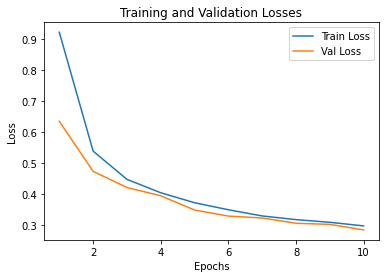

In [25]:
from torchprofile import profile_macs

# Generate random input data for profiling
input_data = torch.randn(1, input_size)

# Calculate FLOPs and number of parameters
macs = profile_macs(model, input_data)
num_params = sum(p.numel() for p in model.parameters())

print(f"Number of parameters: {num_params}")
print(f"FLOPs: {macs}")

# Print confusion matrix
print(f"Confusion Matrix:\n{confusion_matrix.compute()}")

# Print precision and recall scores
print(f"Precision: {precision.compute()}")
print(f"Recall: {recall.compute()}")

# Plotting training and validation losses
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

Input Layer:

The input layer is implicit and is not explicitly defined in the model. It represents the input data, which in this case are 28x28 pixel grayscale images of handwritten digits (MNIST dataset).

Hidden Layers:

Fully Connected Layer 1 (fc1): This layer consists of a fully connected (dense) neural network layer with ReLU activation function. It takes the flattened input data (images) and applies linear transformation to produce an intermediate representation. The ReLU activation function introduces non-linearity to the model, allowing it to learn complex patterns in the data.

Fully Connected Layer 2 (fc2): Similar to the first hidden layer, this layer also consists of a fully connected neural network layer with ReLU activation function. It further processes the intermediate representation obtained from the previous layer.

Output Layer:
        
Fully Connected Layer 3 (fc3): This layer is the output layer of the neural network. It consists of a fully connected neural network layer without any activation function. The output of this layer represents the scores/logits for each class (0-9) in the MNIST dataset.

ReLU Activation Function:

ReLU (Rectified Linear Unit) is an activation function applied after the fully connected layers (fc1 and fc2). It introduces non-linearity to the model, allowing it to learn complex patterns and improve the model's ability to generalize.

The layers are connected sequentially in the forward method of the FFNN class. Each layer takes the output of the previous layer as input and performs a specific transformation. The purpose of each layer is to transform the input data into a form that is progressively more suitable for making predictions. The output layer produces the final predictions for each class (0-9) based on the input data.

In [5]:
#question 2
# Define CNN model
class CNN(nn.Module):
    def __init__(self, num_filters1, num_filters2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_filters1, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=num_filters1, out_channels=num_filters2, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(num_filters2 * 7 * 7, 10)  # 7x7 image size after two max-pool layers
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

**Description of Layers:**

Convolutional Layer 1 (conv1):

Purpose: Extracts features from input images using convolution operation.

Functionality: Applies a convolution operation with 16 filters of size 3x3, followed by ReLU activation.

Max Pooling Layer (pool):

Purpose: Reduces the spatial dimensions of the input volume, reducing the amount of parameters and computation.

Functionality: Performs max pooling operation with a kernel size of 2x2 and a stride of 2.

Convolutional Layer 2 (conv2):

Purpose: Further extracts higher-level features from the feature maps obtained from the previous convolutional layer.

Functionality: Applies a convolution operation with 32 filters of size 3x3, followed by ReLU activation.

Fully Connected Layer (fc):

Purpose: Performs classification based on the extracted features.

Functionality: Takes the flattened output from the last convolutional layer and produces the final output logits for     each class.

In [8]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    
    accuracy = Accuracy(num_classes=num_classes,task='multiclass').to(device)
    precision = Precision(num_classes=num_classes, average='macro', task='multiclass').to(device)
    recall = Recall(num_classes=num_classes, average='macro', task='multiclass').to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                accuracy.update(outputs, labels)
                precision.update(outputs, labels)
                recall.update(outputs, labels)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {accuracy.compute().item():.4f}")

    return model, train_losses, val_losses, accuracy.compute(), precision.compute(), recall.compute()

# Load data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [10]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001
num_filters1 = 16
num_filters2 = 32
print(1)
# Hyperparameter tuning
best_accuracy = 0.0
best_num_filters1 = 0
best_num_filters2 = 0

for num_filters1 in [16,32]:
    for num_filters2 in [32,64]:
        model = CNN(num_filters1, num_filters2).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        _, _, _, accuracy, _, _ = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_num_filters1 = num_filters1
            best_num_filters2 = num_filters2

print(f"Best hyperparameters: Number of filters in Conv1: {best_num_filters1}, "
      f"Number of filters in Conv2: {best_num_filters2}")

# Train with best hyperparameters
model = CNN(best_num_filters1, best_num_filters2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_model, train_losses, val_losses, accuracy, precision, recall = train_model(model, train_loader, val_loader,
                                                                                criterion, optimizer, num_epochs)



1
Epoch 1/10, Train Loss: 0.1830, Val Loss: 0.0732, Val Accuracy: 0.9780
Epoch 2/10, Train Loss: 0.0575, Val Loss: 0.0587, Val Accuracy: 0.9803
Epoch 3/10, Train Loss: 0.0418, Val Loss: 0.0513, Val Accuracy: 0.9825
Epoch 4/10, Train Loss: 0.0352, Val Loss: 0.0502, Val Accuracy: 0.9835
Epoch 5/10, Train Loss: 0.0262, Val Loss: 0.0535, Val Accuracy: 0.9837
Epoch 6/10, Train Loss: 0.0238, Val Loss: 0.0466, Val Accuracy: 0.9845
Epoch 7/10, Train Loss: 0.0187, Val Loss: 0.0511, Val Accuracy: 0.9848
Epoch 8/10, Train Loss: 0.0154, Val Loss: 0.0507, Val Accuracy: 0.9850
Epoch 9/10, Train Loss: 0.0140, Val Loss: 0.0596, Val Accuracy: 0.9849
Epoch 10/10, Train Loss: 0.0104, Val Loss: 0.0613, Val Accuracy: 0.9850
Best hyperparameters: Number of filters in Conv1: 16, Number of filters in Conv2: 32
Epoch 1/10, Train Loss: 0.1821, Val Loss: 0.0754, Val Accuracy: 0.9769
Epoch 2/10, Train Loss: 0.0590, Val Loss: 0.0632, Val Accuracy: 0.9794
Epoch 3/10, Train Loss: 0.0434, Val Loss: 0.0520, Val Accura

TypeError: Accuracy.__new__() missing 1 required positional argument: 'task'

Test Loss: 0.0452, Test Accuracy: 0.9880


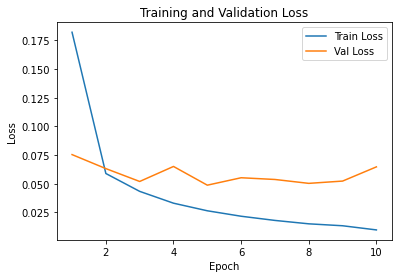

In [11]:
# Evaluation on test set
test_loss = 0.0
test_accuracy = Accuracy(num_classes=num_classes,task='multiclass').to(device)
test_precision = Precision(num_classes=10,task='multiclass', average='macro').to(device)
test_recall = Recall(num_classes=10,task='multiclass', average='macro').to(device)
criterion = nn.CrossEntropyLoss()


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        test_accuracy.update(outputs, labels)
        test_precision.update(outputs, labels)
        test_recall.update(outputs, labels)

test_loss /= len(test_loader.dataset)
test_accuracy = test_accuracy.compute()
test_precision = test_precision.compute()
test_recall = test_recall.compute()

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Visualize training and validation loss
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()